In [38]:
#import sys
#sys.version
import modelbase
import modelbase.ratelaws as rl
from weisse import WeisseBaseModel

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import qtb_plot


In [3]:
defaultParameters = { 's': 1e4,  # external nutrient [ molecs ]
                      'dm': 0.1,  # mRNA degradation rate [1/min ]
                      'ns': 0.8,  # nutrient efficiency [ none ]
                      'nr': 7459,  # ribosome length [ aa / molecs ]
                      'nt': 300,  # length of non-ribosomal proteins [ aa / molecs ]
                      'nm': 300,  # length of non-ribosomal proteins [ aa / molecs ]
                      'nq': 300,  # length of non-ribosomal proteins [ aa / molecs ]
                      'gammamax': 1260,  # max. transl. elongation rate [ aa / min molecs ]
                      'Kgamma': 7,  # transl. elongation threshold [ molecs / cell ]
                      'vt': 726,  # max. nutrient import rate [ 1/min ]
                      'Kt': 1000,  # nutrient import threshold [ molecs ]
                      'vm': 5800,  # max. enzymatic rate [ 1/min ]
                      'Km': 1000,  # enzymatic threshold
                      'wr': 930,  # max. ribosome transcription rate [ molecs / min cell ]
                      'wt': 4.14,  # max. enzyme transcription rate [ molecs / min cell ]
                      'wm': 4.14,  # max. enzyme transcription rate [ molecs / min cell ]
                      'wq': 948.93,  # max. q-transcription rate
                      'thetar': 426.87,  # ribosome transcription threshold [ molecs / cell ]
                      'thetat': 4.38,  # non-ribosomal transcription threshold [ molecs / cell ]
                      'thetam': 4.38,  # non-ribosomal transcription threshold [ molecs / cell ]
                      'thetaq': 4.38,  # non-ribosomal transcription threshold [ molecs / cell ]
                      'Kq': 152219,  # q-autoinhibition threshold [ molecs / cell ]
                      'hq': 4,  # q-autoinhibition Hill coeff. [ none ]
                      'kb': 1,  # mRNA-ribosome binding rate
                      'ku': 1,  # mRNA-ribosome unbinding rate
                      'M': 1e8,  # total cell mass
                      'kcm': 0.00599  # chloramphenicol-binding rate
}

In [4]:
indexx = ['r','t','m','q']
cl = ['si','a','mr','mt','mm','mq', 'cr','ct','cm','cq','pr','pt','pm','pq']

In [5]:
qtb_plot.set("notebook")

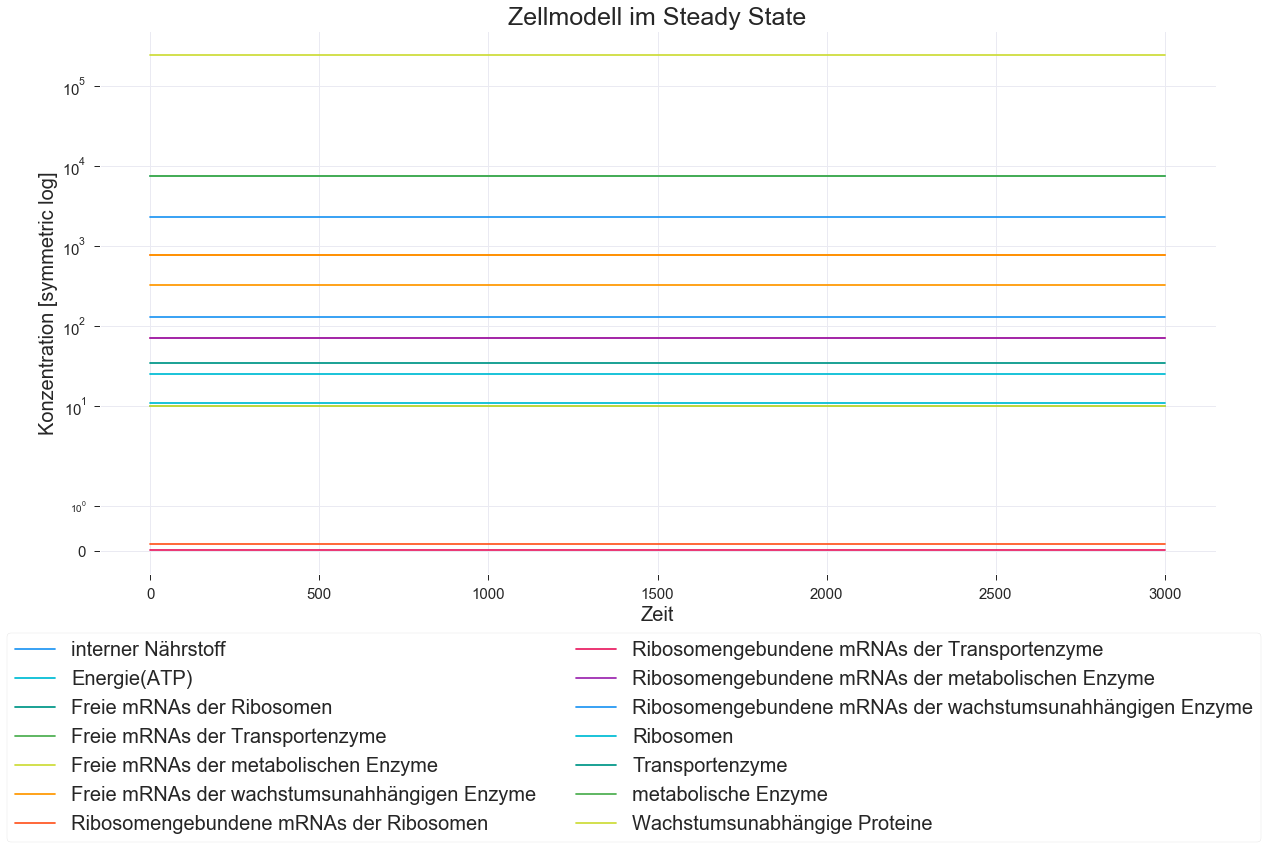

In [6]:
m = WeisseBaseModel()
s = modelbase.Simulator(m)
#                         ['si',       'a',     'mr',     'mt',   'mm',    'mq',    'cr', 'ct', 'cm', 'cq', 'pr',   'pt',    'pm',     'pq']
#weise_values = np.array([31096.192, 43297.502, 8514.558, 49.333, 49.333, 8811.960, 348.675, 0, 357.898, 0, 0.0414, 471.364, 471.364 , 471.364])
#steady-werte
weise_values = np.array([1.28404576e+02, 1.06993966e+01, 3.40489668e+01, 9.92041693e+00,
       9.92041693e+00, 3.22208841e+02, 7.62864257e+02, 7.02616857e+01,
       7.02616857e+01, 2.28205493e+03, 2.52364073e+01, 7.35237302e+03,
       7.35237302e+03, 2.38800406e+05])
s.timeCourse(np.linspace(0,3000,100),weise_values); 
#s.timeCourse(np.linspace(0,10000,1000),np.ones(14));

clnamen = ['interner Nährstoff','Energie(ATP)',
      'Freie mRNAs der Ribosomen','Freie mRNAs der Transportenzyme','Freie mRNAs der metabolischen Enzyme','Freie mRNAs der wachstumsunahhängigen Enzyme',
      'Ribosomengebundene mRNAs der Ribosomen','Ribosomengebundene mRNAs der Transportenzyme','Ribosomengebundene mRNAs der metabolischen Enzyme','Ribosomengebundene mRNAs der wachstumsunahhängigen Enzyme',
'Ribosomen','Transportenzyme','metabolische Enzyme','Wachstumsunabhängige Proteine', 'gamma','Inhibition der wachstumsunahhängigen Enzyme', 'Wachstum']

# Plotten Sie die zeitliche Entwicklung
plt.figure(figsize=(20,10))
plt.title('Zellmodell im Steady State', size = 25)
plt.xlabel('Zeit', size = 20)
plt.ylabel('Konzentration [symmetric log]', size = 20)
plt.yscale('symlog')
plt.xticks(size = 15)
plt.yticks(size = 15)
lines = plt.plot(s.getT(),s.getY(), '-')
plt.legend(lines[:14], clnamen, prop = {'size': 20}, loc = 'center right', frameon=True, ncol=2, bbox_to_anchor=[1.05,-0.3])

plt.draw_if_interactive()
plt.show()

#colors = ['black', 'red', 'gold', 'olivedrab', 'chartreuse', 'darkgreen', 'darkcyan', 'royalblue', 'darkorchild', 'plum', 'darkorange', 'sienna', 'yellow', 'pink']

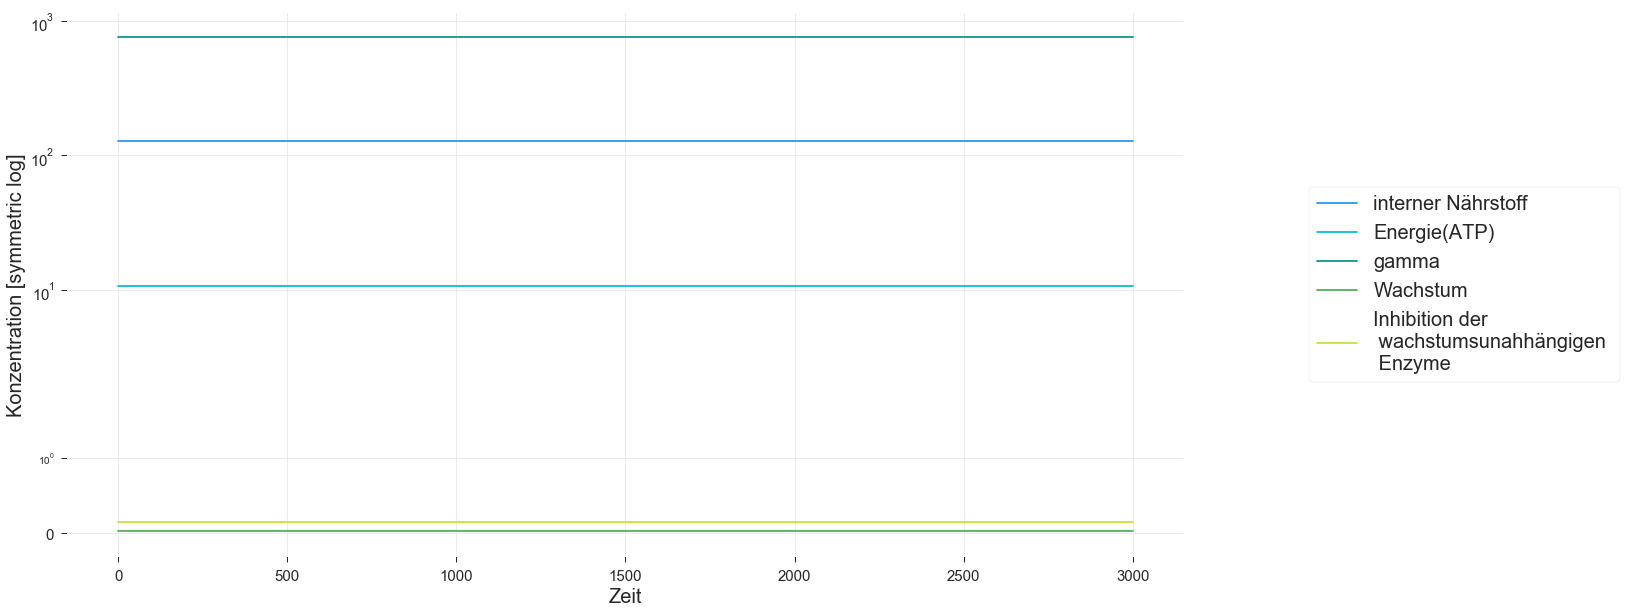

In [33]:
line_labels =['interner Nährstoff','Energie(ATP)','gamma', 'Wachstum','Inhibition der \n wachstumsunahhängigen \n Enzyme',
              'Freie mRNAs der \n Ribosomen','Freie mRNAs der \n Transportenzyme','Freie mRNAs der \n metabolischen Enzyme','Freie mRNAs der \n wachstumsunahhängigen \n Enzyme',
              'Ribosomengebundene mRNAs der \n Ribosomen','Ribosomengebundene mRNAs der \n Transportenzyme','Ribosomengebundene mRNAs der \n metabolischen Enzyme','Ribosomengebundene mRNAs der \n wachstumsunahhängigen Enzyme',
              'Ribosomen','Transportenzyme','metabolische Enzyme','Wachstumsunabhängige Proteine               ']

plt.figure(figsize=(20,10))
#plt.title('Zellmodell im Steady State', size = 25)
plt.xlabel('Zeit', size = 20)
plt.ylabel('Konzentration [symmetric log]', size = 20)
plt.yscale('symlog')
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.plot(s.getT(),si, '-', label = line_labels[0])
plt.plot(s.getT(),a, '-',label = line_labels[1])
plt.plot(s.getT(),gamma, '-',label = line_labels[2])
plt.plot(s.getT(),wachstum, '-',label = line_labels[3])
plt.plot(s.getT(),inhibitionq, '-',label = line_labels[4])
plt.legend( prop = {'size': 20}, loc = 'center right', frameon=True, bbox_to_anchor=[1.4,0.5])

plt.draw_if_interactive()
plt.show()

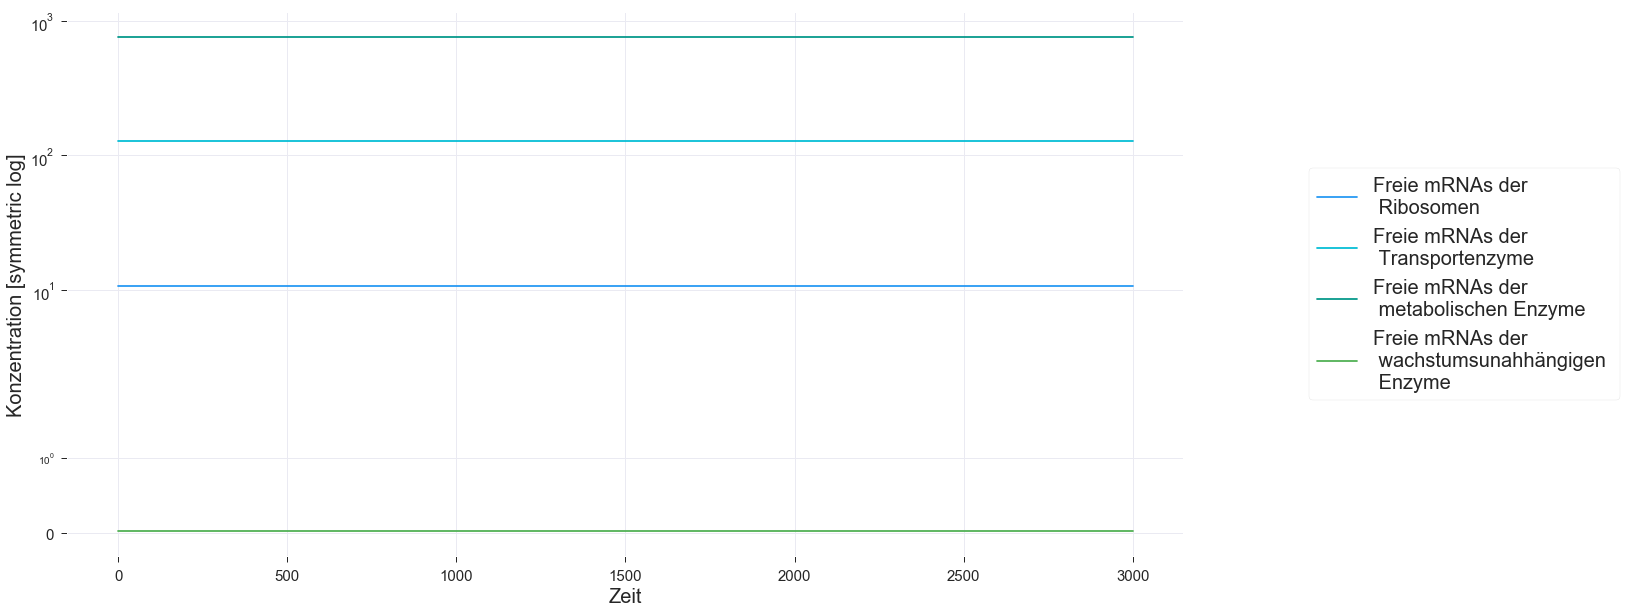

In [32]:
plt.figure(figsize=(20,10))
#plt.title('Zellmodell im Steady State', size = 25)
plt.xlabel('Zeit', size = 20)
plt.ylabel('Konzentration [symmetric log]', size = 20)
plt.yscale('symlog')
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.plot(s.getT(),a, '-', label = line_labels[5])
plt.plot(s.getT(),si, '-',label = line_labels[6])
plt.plot(s.getT(),gamma, '-',label = line_labels[7])
plt.plot(s.getT(),wachstum, '-',label = line_labels[8])
plt.legend( prop = {'size': 20}, loc = 'center right', frameon=True, bbox_to_anchor=[1.4,0.5])

plt.draw_if_interactive()
plt.show()

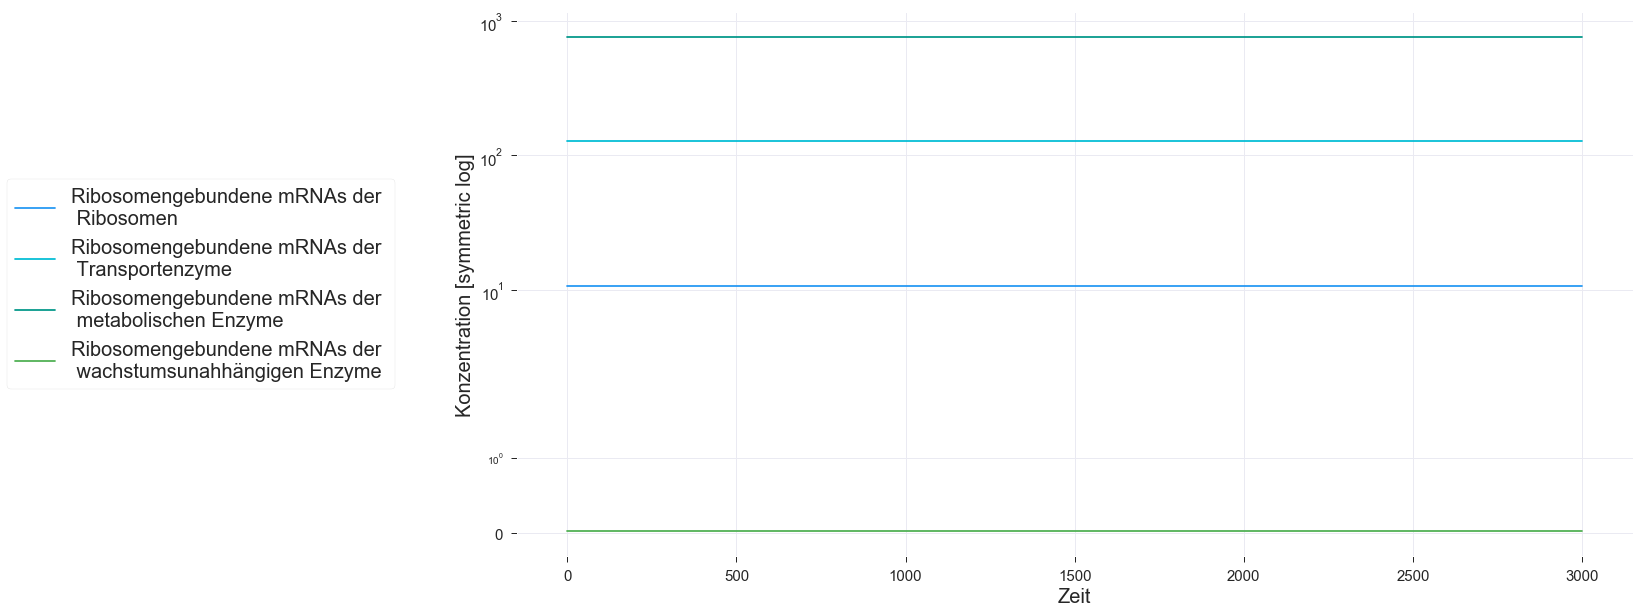

In [26]:
plt.figure(figsize=(20,10))
#plt.title('Zellmodell im Steady State', size = 25)
plt.xlabel('Zeit', size = 20)
plt.ylabel('Konzentration [symmetric log]', size = 20)
plt.yscale('symlog')
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.plot(s.getT(),a, '-', label = line_labels[9])
plt.plot(s.getT(),si, '-',label = line_labels[10])
plt.plot(s.getT(),gamma, '-',label = line_labels[11])
plt.plot(s.getT(),wachstum, '-',label = line_labels[12])
plt.legend( prop = {'size': 20}, loc = 'center right', frameon=True, bbox_to_anchor=[-0.1,0.5])

plt.draw_if_interactive()
plt.show()

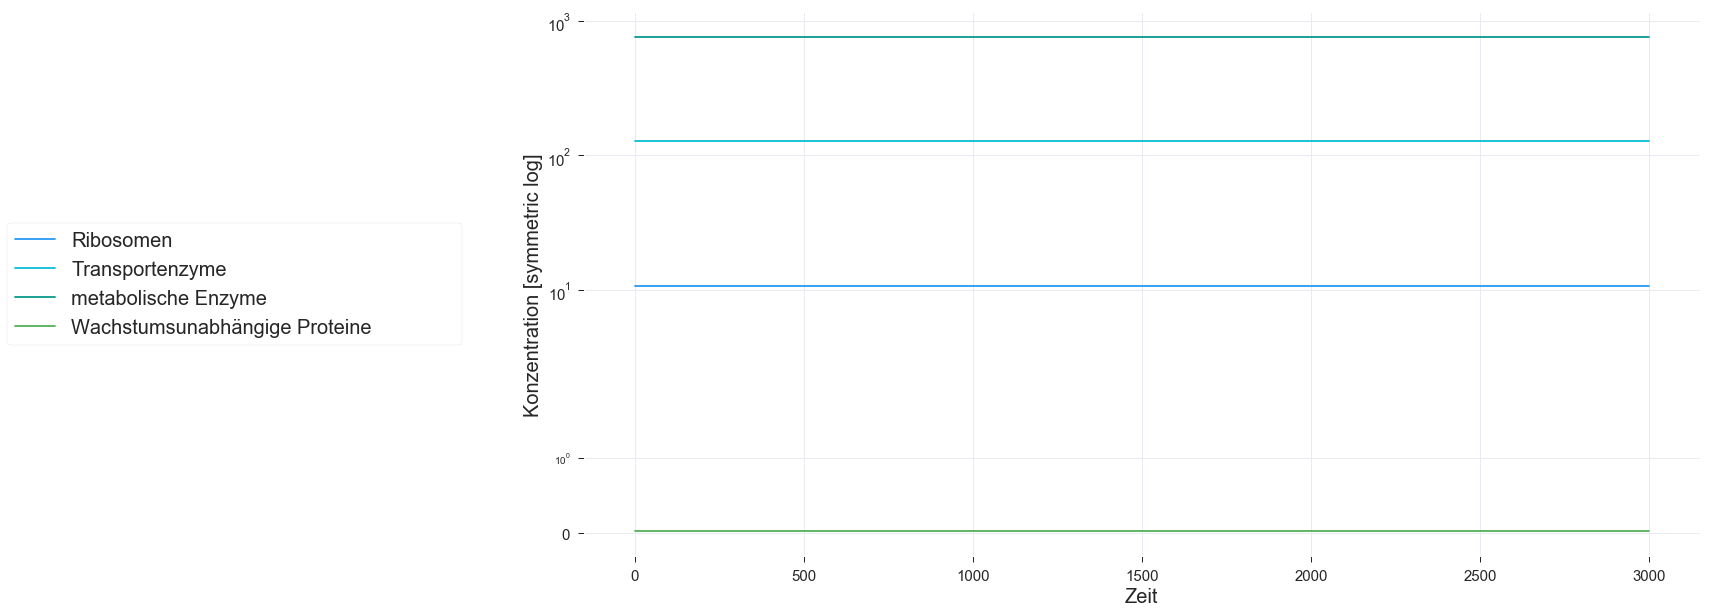

In [28]:
plt.figure(figsize=(20,10))
#plt.title('Zellmodell im Steady State', size = 25)
plt.xlabel('Zeit', size = 20)
plt.ylabel('Konzentration [symmetric log]', size = 20)
plt.yscale('symlog')
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.plot(s.getT(),a, '-', label = line_labels[13])
plt.plot(s.getT(),si, '-',label = line_labels[14])
plt.plot(s.getT(),gamma, '-',label = line_labels[15])
plt.plot(s.getT(),wachstum, '-',label = line_labels[16])
plt.legend( prop = {'size': 20}, loc = 'center right', frameon=True, bbox_to_anchor=[-0.1,0.5])

plt.draw_if_interactive()
plt.show()

In [16]:
m = WeisseBaseModel()
s = modelbase.Simulator(m)
#                         ['si',       'a',     'mr',     'mt',   'mm',    'mq',    'cr', 'ct', 'cm', 'cq', 'pr',   'pt',    'pm',     'pq']
#weise_values = np.array([31096.192, 43297.502, 8514.558, 49.333, 49.333, 8811.960, 348.675, 0, 357.898, 0, 0.0414, 471.364, 471.364 , 471.364])
#steady-werte
weise_values = np.array([1.28404576e+02, 1.06993966e+01, 3.40489668e+01, 9.92041693e+00,
       9.92041693e+00, 3.22208841e+02, 7.62864257e+02, 7.02616857e+01,
       7.02616857e+01, 2.28205493e+03, 2.52364073e+01, 7.35237302e+03,
       7.35237302e+03, 2.38800406e+05])
s.timeCourse(np.linspace(0,10000,100),weise_values); 
#s.timeCourse(np.linspace(0,10000,1000),np.ones(14));

clnamen = ['interner Nährstoff','Energie(ATP)',
      'Freie mRNAs der Ribosomen','Freie mRNAs der Transportenzyme','Freie mRNAs der metabolischen Enzyme','Freie mRNAs der wachstumsunahhängigen Enzyme',
      'Ribosomengebundene mRNAs der Ribosomen','Ribosomengebundene mRNAs der Transportenzyme','Ribosomengebundene mRNAs der metabolischen Enzyme','Ribosomengebundene mRNAs der wachstumsunahhängigen Enzyme',
'Ribosomen','Transportenzyme','metabolische Enzyme','Wachstumsunabhängige Proteine', 'gamma','Inhibition der wachstumsunahhängigen Enzyme', 'Wachstum']

# Plotten Sie die zeitliche Entwicklung
plt.figure(figsize=(20,10))
plt.title('Zellmodell im Steady State', size = 25)
plt.xlabel('Zeit', size = 20)
plt.ylabel('Konzentration', size = 20)
plt.yscale('symlog')
plt.xticks(size = 15)
plt.yticks(size = 15)
lines = plt.plot(s.getT(),s.getY(), '-')
plt.legend(lines[:14], clnamen, prop = {'size': 20}, loc = 'center right', frameon=True, ncol=2, bbox_to_anchor=[1.05,-0.3])

plt.draw_if_interactive()
plt.show()

#colors = ['black', 'red', 'gold', 'olivedrab', 'chartreuse', 'darkgreen', 'darkcyan', 'royalblue', 'darkorchild', 'plum', 'darkorange', 'sienna', 'yellow', 'pink']

array([1.28404576e+02, 1.06993966e+01, 3.40489668e+01, 9.92041693e+00,
       9.92041693e+00, 3.22208841e+02, 7.62864257e+02, 7.02616857e+01,
       7.02616857e+01, 2.28205493e+03, 2.52364073e+01, 7.35237302e+03,
       7.35237302e+03, 2.38800406e+05, 7.61677926e+02, 1.41701254e-01,
       2.42628128e-02])

In [74]:
test = []
for i, data in enumerate(s.getY()):
    test.append(s.getY()[i][0])

In [8]:
si = []
a = []
mr = []
mt = []
mm = []
mq = []
cr = []
ct = []
cm = []
cq = []
pr = []
pt = []
pm = []
pq = []
gamma = []
inhibitionq = []
wachstum = []

for i, data in enumerate(s.getY()):
    si.append(s.getY()[i][0])
    a.append(s.getY()[i][1])
    mr.append(s.getY()[i][2])
    mt.append(s.getY()[i][3])
    mm.append(s.getY()[i][4])
    mq.append(s.getY()[i][5])
    cr.append(s.getY()[i][6])
    ct.append(s.getY()[i][7])
    cm.append(s.getY()[i][8])
    cq.append(s.getY()[i][9])
    pr.append(s.getY()[i][10])
    pt.append(s.getY()[i][11])
    pm.append(s.getY()[i][12])
    pq.append(s.getY()[i][13])
    gamma.append(s.getY()[i][14])
    inhibitionq.append(s.getY()[i][15])
    wachstum.append(s.getY()[i][16])

In [128]:
x = s.getT()
time = x.tolist()
time

[0.0,
 30.303030303030305,
 60.60606060606061,
 90.9090909090909,
 121.21212121212122,
 151.51515151515153,
 181.8181818181818,
 212.12121212121212,
 242.42424242424244,
 272.72727272727275,
 303.03030303030306,
 333.33333333333337,
 363.6363636363636,
 393.93939393939394,
 424.24242424242425,
 454.54545454545456,
 484.8484848484849,
 515.1515151515151,
 545.4545454545455,
 575.7575757575758,
 606.0606060606061,
 636.3636363636364,
 666.6666666666667,
 696.969696969697,
 727.2727272727273,
 757.5757575757576,
 787.8787878787879,
 818.1818181818182,
 848.4848484848485,
 878.7878787878789,
 909.0909090909091,
 939.3939393939395,
 969.6969696969697,
 1000.0,
 1030.3030303030303,
 1060.6060606060607,
 1090.909090909091,
 1121.2121212121212,
 1151.5151515151515,
 1181.818181818182,
 1212.1212121212122,
 1242.4242424242425,
 1272.7272727272727,
 1303.030303030303,
 1333.3333333333335,
 1363.6363636363637,
 1393.939393939394,
 1424.2424242424242,
 1454.5454545454545,
 1484.848484848485,
 1515

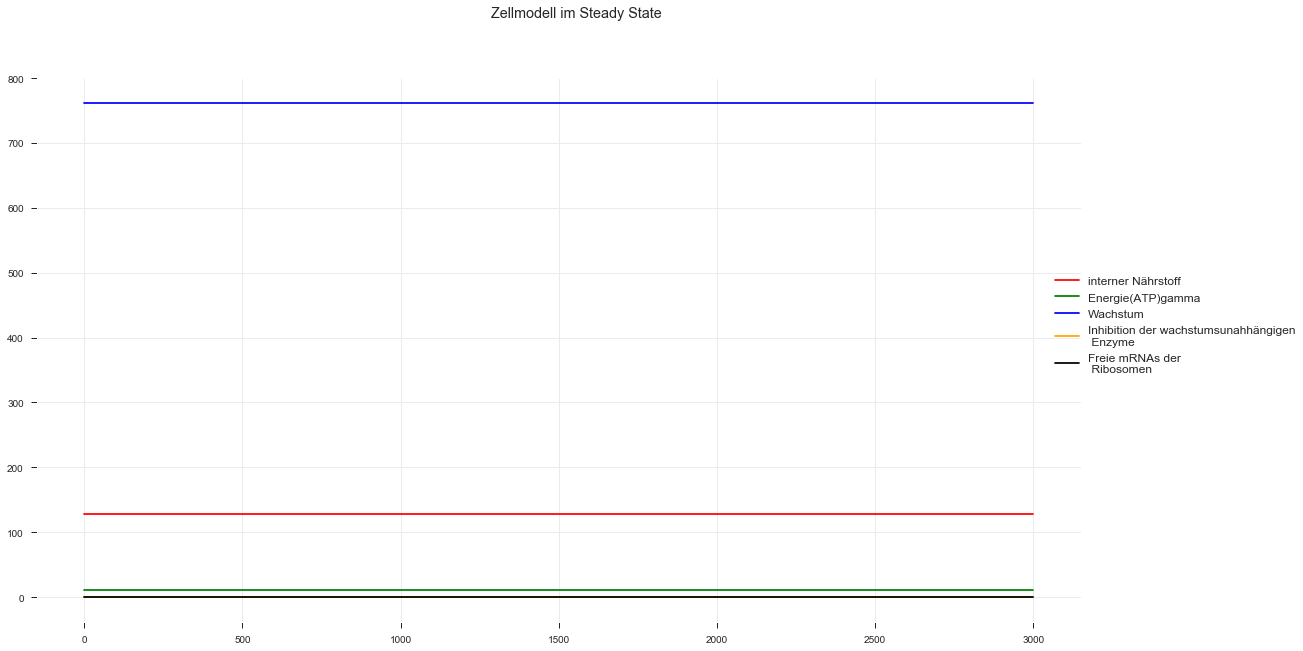

In [264]:
#fig, Plotlist = plt.subplots(2,2,figsize=(20,10))
fig, (ax1) = plt.subplots(1,1,figsize=(20,10))
fig.suptitle('Zellmodell im Steady State')

# The data
x =  time
y1 = si
y2 = a
y3 = gamma
y4 = wachstum
y17 = inhibitionq

y5 = mr
y6 = mt
y7 = mm
y8 = mq

y9 = cr
y10 = ct
y11 = cm
y12 = cq

y13 = pr
y14 = pt
y15 = pm
y16 = pq

# Labels to use in the legend for each line
#line_labels = ["si", "a", "gamma", "Wachstum", "inhibitionq", "mr", "mt", "mm", "mq", "cr", "ct", "cm", "cq", "pr", "pt", "pm", "pq"]
line_labels =['interner Nährstoff','Energie(ATP)''gamma', 'Wachstum','Inhibition der wachstumsunahhängigen \n Enzyme',
              'Freie mRNAs der \n Ribosomen','Freie mRNAs der \n Transportenzyme','Freie mRNAs der \n metabolischen Enzyme','Freie mRNAs der \n wachstumsunahhängigen Enzyme',
              'Ribosomengebundene mRNAs der \n Ribosomen','Ribosomengebundene mRNAs der \n Transportenzyme','Ribosomengebundene mRNAs der \n metabolischen Enzyme','Ribosomengebundene mRNAs der \n wachstumsunahhängigen Enzyme',
              'Ribosomen','Transportenzyme','metabolische Enzyme','Wachstumsunabhängige Proteine               ']

# Create the sub-plots, assigning a different color for each line.
# Also store the line objects created
l1 = ax1.plot(x, y1, color="red")[0]
l2 = ax1.plot(x, y2, color="green")[0]
l3 = ax1.plot(x, y3, color="blue")[0]
l4 = ax1.plot(x, y4, color="orange")[0]
l17 = ax1.plot(x, y17, color="black")[0]# A second line in the third subplot

#l5 = ax2.plot(x, y5, color="darkorange")[0]
#l6 = ax2.plot(x, y6, color="navy")[0]
#l7 = ax2.plot(x, y7, color="springgreen")[0]
#l8 = ax2.plot(x, y8, color="firebrick")[0] # A second line in the third subplot

#l9 = ax3.plot(x, y9, color="m")[0]
#l10 = ax3.plot(x, y10, color="lime")[0]
#l11 = ax3.plot(x, y11, color="skyblue")[0]
#l12 = ax3.plot(x, y12, color="tan")[0] # A second line in the third subplot

#l13 = ax4.plot(x, y13, color="chocolate")[0]
#l14 = ax4.plot(x, y14, color="teal")[0]
#l15 = ax4.plot(x, y15, color="steelblue")[0]
#l16 = ax4.plot(x, y16, color="hotpink")[0] # A second line in the third subplot


# Create the legend
fig.legend([l1, l2, l3, l4, l17, l5, l6, l7, l8, l9, l10, l11, l12, l13, l14, l15, l16],     # The line objects
           labels=line_labels,   # The labels for each line
           loc="center right", # Position of legend
           prop={'size': 12},
           #ncol=2,
           borderaxespad=0.01    # Small spacing around legend box
           #title="Legend Title"  # Title for the legend
           )
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),&nbsp; shadow=True, ncol=2)
# Adjust the scaling factor to fit your legend text completely outside the plot
# (smaller value results in more space being made for the legend)
plt.subplots_adjust(right=0.85)


plt.show()

In [255]:
s.getY()[-1]

array([1.28404576e+02, 1.06993966e+01, 3.40489668e+01, 9.92041693e+00,
       9.92041693e+00, 3.22208841e+02, 7.62864257e+02, 7.02616857e+01,
       7.02616857e+01, 2.28205493e+03, 2.52364073e+01, 7.35237302e+03,
       7.35237302e+03, 2.38800406e+05, 7.61677926e+02, 1.41701254e-01,
       2.42628128e-02])

In [22]:
s.getVarsByName(cl)

array([[3.10961920e+04, 4.32975020e+04, 8.51455800e+03, ...,
        4.71364000e+02, 4.71364000e+02, 4.71364000e+02],
       [6.97738625e+01, 1.07989264e+00, 4.89644282e+02, ...,
        4.89995294e+02, 8.54884000e+02, 8.61773491e+03],
       [6.93108933e+01, 1.11140886e+00, 8.60304119e+01, ...,
        5.27986911e+02, 9.26918027e+02, 2.21127836e+04],
       ...,
       [1.28404576e+02, 1.06993966e+01, 3.40489668e+01, ...,
        7.35237302e+03, 7.35237302e+03, 2.38800406e+05],
       [1.28404576e+02, 1.06993966e+01, 3.40489668e+01, ...,
        7.35237302e+03, 7.35237302e+03, 2.38800406e+05],
       [1.28404576e+02, 1.06993966e+01, 3.40489668e+01, ...,
        7.35237302e+03, 7.35237302e+03, 2.38800406e+05]])

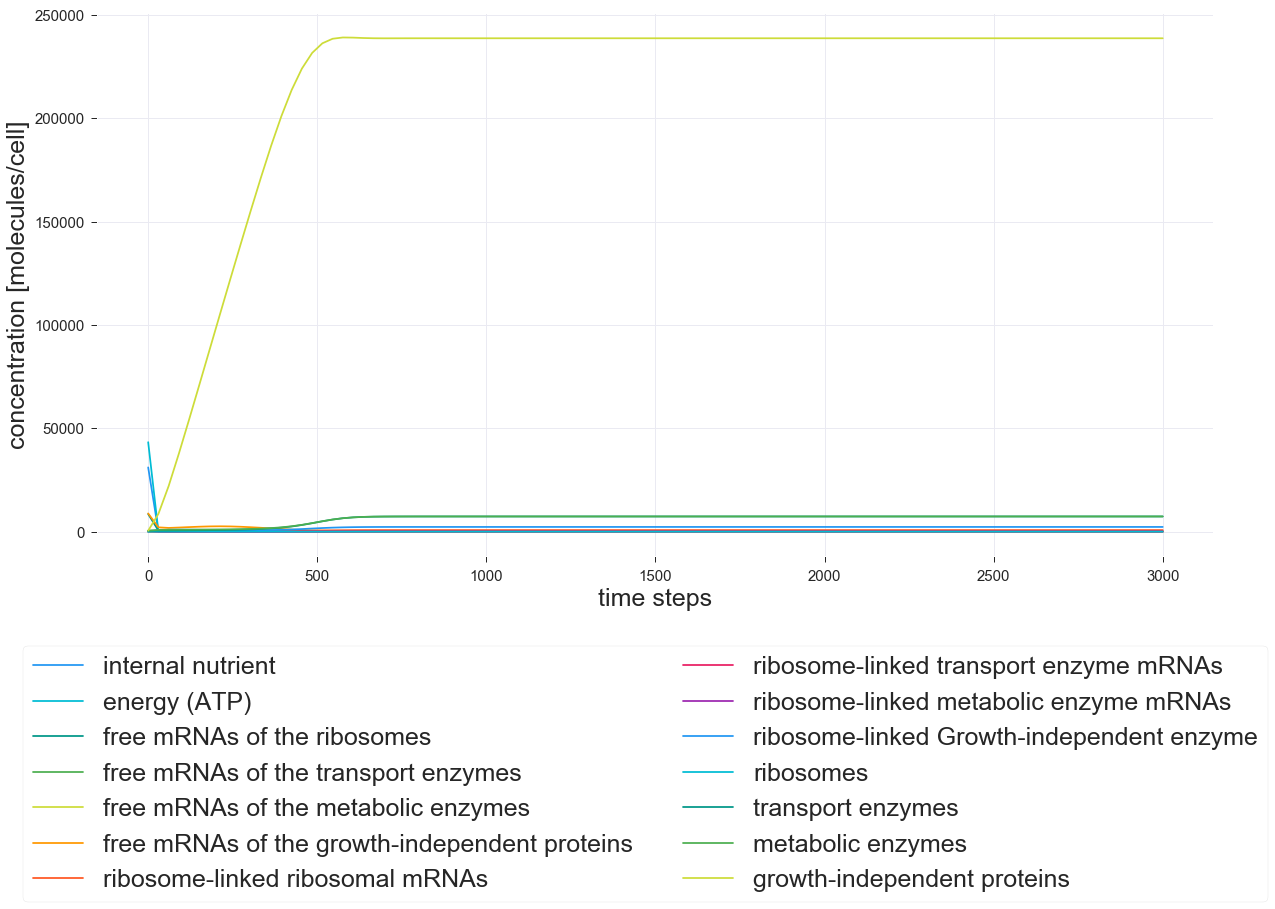

In [41]:
valuesOneHundredTimeSteps, valuesLastTimeStep = [],[]
m = WeisseBaseModel()
s = modelbase.Simulator(m)
#                         ['si',       'a',     'mr',     'mt',   'mm',    'mq',    'cr', 'ct', 'cm', 'cq', 'pr',   'pt',    'pm',     'pq']
weise_values = np.array([31096.192, 43297.502, 8514.558, 49.333, 49.333, 8811.960, 348.675, 0, 357.898, 0, 0.0414, 471.364, 471.364 , 471.364])
changedValuesOverTimeArray = s.timeCourse(np.linspace(0,3000,100),weise_values);
valuesOneHundredTimeSteps.append(changedValuesOverTimeArray)
valuesLastTimeStep.append(changedValuesOverTimeArray[-1])


['si','a','mr','mt','mm','mq', 'cr','ct','cm','cq','pr','pt','pm','pq']
clnamen = ['internal nutrient', 'energy (ATP)','free mRNAs of the ribosomes', 'free mRNAs of the transport enzymes', 'free mRNAs of the metabolic enzymes', 'free mRNAs of the growth-independent proteins',
           'ribosome-linked ribosomal mRNAs', 'ribosome-linked transport enzyme mRNAs', 'ribosome-linked metabolic enzyme mRNAs', 'ribosome-linked Growth-independent enzyme',
           'ribosomes', 'transport enzymes', 'metabolic enzymes','growth-independent proteins']

# Plotten Sie die zeitliche Entwicklung
plt.figure(figsize=(20,10))
#plt.title('Cell model with parameters from the paper', size = 20)
plt.xlabel('time steps', size = 25)
plt.ylabel('concentration [molecules/cell]', size = 25)
plt.xticks(size = 15)
plt.yticks(size = 15)
lines = plt.plot(s.getT(),s.getVarsByName(cl),'-')
plt.legend(lines[:14], clnamen, prop = {'size': 25}, loc = 'center right', frameon=True, ncol=2,  bbox_to_anchor=[1.06,-0.4])

plt.draw_if_interactive()
plt.show()

In [53]:
werteq, wertem, wertet, werter = [], [], [], []
for i, date in enumerate(valuesOneHundredTimeSteps[0]):
    werteq.append(valuesOneHundredTimeSteps[0][i][13]*300)
    wertem.append(valuesOneHundredTimeSteps[0][i][12]*300)
    wertet.append(valuesOneHundredTimeSteps[0][i][11]*300)
    werter.append(valuesOneHundredTimeSteps[0][i][10]*7459)
    

NameError: name 'werter' is not defined

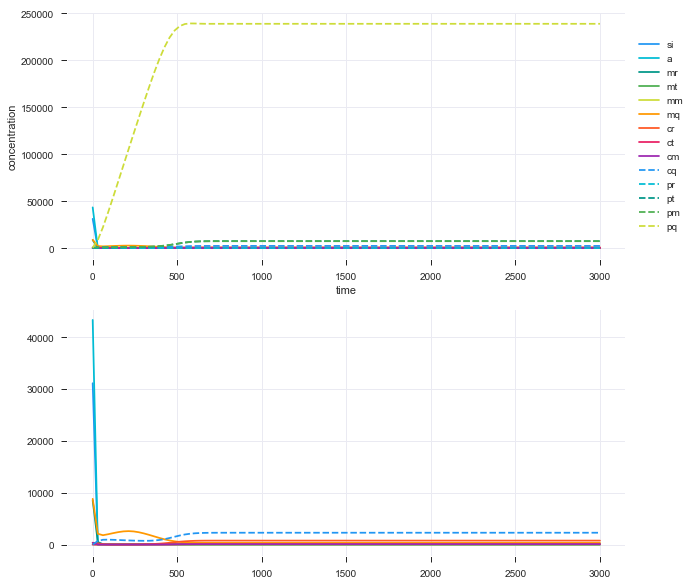

In [8]:
# Plotten Sie die zeitliche Entwicklung
fig, Plotlist = plt.subplots(2,1,figsize=(10,10))
Plotlist = Plotlist.ravel()
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[0:1]),label = cl[0])
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[1:2]),label = cl[1])
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[2:3]),label = cl[2])
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[3:4]),label = cl[3])
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[4:5]),label = cl[4])
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[5:6]),label = cl[5])
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[6:7]),label = cl[6])
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[7:8]),label = cl[7])
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[8:9]),label = cl[8])
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[9:10]),label = cl[9])
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[10:11]), label = cl[10])
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[11:12]),label = cl[11])
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[12:13]),label = cl[12])
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[13:14]),label = cl[13])
#Plotlist[0].set_title('si, a')
Plotlist[0].set_xlabel('time')
Plotlist[0].set_ylabel('concentration')
Plotlist[0].legend(loc = 'center right', bbox_to_anchor=(1.12, 0.5))


Plotlist[1].plot(s.getT(),s.getVarsByName(cl[0:1]),label = cl[0])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[1:2]),label = cl[1])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[2:3]),label = cl[2])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[3:4]),label = cl[3])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[4:5]),label = cl[4])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[5:6]),label = cl[5])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[6:7]),label = cl[6])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[7:8]),label = cl[7])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[8:9]),label = cl[8])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[9:10]),label = cl[9])
Plotlist[1].plot(s.getT(),werter, label = cl[10])
Plotlist[1].plot(s.getT(),wertet,label = cl[11])
Plotlist[1].plot(s.getT(),wertem,label = cl[12])
Plotlist[1].plot(s.getT(),werteq,label = cl[13])
#Plotlist[1].set_title('si, a')
Plotlist[1].set_xlabel('time')
Plotlist[1].set_ylabel('concentration')
Plotlist[1].legend(loc = 'center right', bbox_to_anchor=(1.12, 0.5))

In [36]:
valuesOneHundredTimeSteps[0][1][13]

8617.734914295621

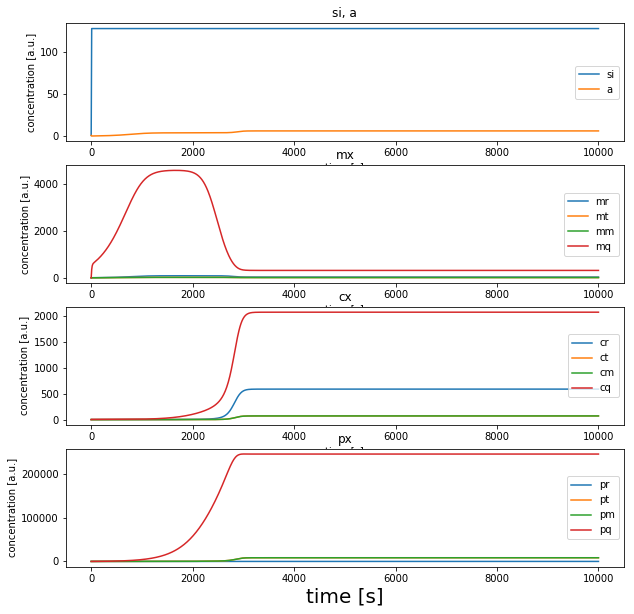

In [6]:
# Plotten Sie die zeitliche Entwicklung
fig, Plotlist = plt.subplots(4,1,figsize=(10,10))
Plotlist = Plotlist.ravel()
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[0:1]),label = cl[0])
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[1:2]),label = cl[1])
Plotlist[0].set_title('si, a')
Plotlist[0].set_xlabel('time [s]')
Plotlist[0].set_ylabel('concentration [a.u.]')
Plotlist[0].legend(loc = 'center right')


Plotlist[1].plot(s.getT(),s.getVarsByName(cl[2:3]),label = cl[2])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[3:4]),label = cl[3])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[4:5]),label = cl[4])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[5:6]),label = cl[5])
Plotlist[1].set_title('mx')
Plotlist[1].set_xlabel('time [s]')
Plotlist[1].set_ylabel('concentration [a.u.]')
Plotlist[1].legend(loc = 'center right')


Plotlist[2].plot(s.getT(),s.getVarsByName(cl[6:7]),label = cl[6])
Plotlist[2].plot(s.getT(),s.getVarsByName(cl[7:8]),label = cl[7])
Plotlist[2].plot(s.getT(),s.getVarsByName(cl[8:9]),label = cl[8])
Plotlist[2].plot(s.getT(),s.getVarsByName(cl[9:10]),label = cl[9])
Plotlist[2].set_title('cx')
Plotlist[2].set_xlabel('time [s]')
Plotlist[2].set_ylabel('concentration [a.u.]')
Plotlist[2].legend(loc = 'center right')


Plotlist[3].plot(s.getT(),s.getVarsByName(cl[10:11]), label = cl[10])
Plotlist[3].plot(s.getT(),s.getVarsByName(cl[11:12]),label = cl[11])
Plotlist[3].plot(s.getT(),s.getVarsByName(cl[12:13]),label = cl[12])
Plotlist[3].plot(s.getT(),s.getVarsByName(cl[13:14]),label = cl[13])
Plotlist[3].set_title('px')
Plotlist[3].set_xlabel('time [s]', size = 20)
Plotlist[3].set_ylabel('concentration [a.u.]')
Plotlist[3].legend(loc = 'center right')


[0.00890138 0.000938   0.00094564 0.00095571 0.00096829 0.0009829
 0.00099893 0.00101592 0.00103358 0.00105169 0.00107014 0.00108883
 0.00110773 0.0011268  0.00114601 0.00116538 0.00118488 0.00120453
 0.00122432 0.00124428 0.00126442 0.00128475 0.00130531 0.00132612
 0.00134722 0.00136865 0.00139046 0.00141271 0.00143545 0.00145876
 0.00148272 0.00150742 0.00153295 0.00155943 0.00158698 0.00161573
 0.00164583 0.00167744 0.00171074 0.00174592 0.0017832  0.0018228
 0.001865   0.00191006 0.00195829 0.00201003 0.00206565 0.00212554
 0.00219015 0.00225994 0.00233544 0.00241722 0.00250588 0.0026021
 0.00270658 0.00282009 0.00294347 0.00307759 0.00322338 0.00338182
 0.00355394 0.00374079 0.00394346 0.00416304 0.00440058 0.00465712
 0.00493358 0.00523077 0.00554932 0.00588962 0.00625175 0.00663545
 0.00704002 0.0074643  0.00790661 0.00836475 0.00883598 0.00931709
 0.00980441 0.01029397 0.01078158 0.01126294 0.01173387 0.01219038
 0.01262886 0.01304617 0.01343973 0.01380759 0.01414844 0.0144615

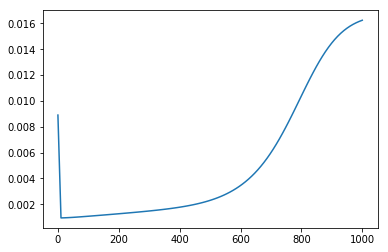

In [15]:
# von jedem zeitschritt aus 100 ist in blub der letzte wert
blub = s.getY()[:,16]
print(blub)
plt.plot(s.getT(),s.getY()[:,16]) #3.10961920e+04

In [8]:
s.model.par.ns

0.3

In [32]:
'''
# Plotten Sie die zeitliche Entwicklung
plt.figure(figsize=(20,10))
plt.title('Cell model with parameters from the paper', size = 20)
plt.xlabel('time [s]', size = 20)
plt.ylabel('concentration [a.u.]', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
lines = plt.plot(s.getT(),s.getVarsByName(cl[]))
plt.legend(lines[:14], cl, prop = {'size': 20}, loc = 'center right', frameon=True, ncol=2)

plt.draw_if_interactive()
plt.show()
'''

"\n# Plotten Sie die zeitliche Entwicklung\nplt.figure(figsize=(20,10))\nplt.title('Cell model with parameters from the paper', size = 20)\nplt.xlabel('time [s]', size = 20)\nplt.ylabel('concentration [a.u.]', size = 20)\nplt.xticks(size = 15)\nplt.yticks(size = 15)\nlines = plt.plot(s.getT(),s.getVarsByName(cl[]))\nplt.legend(lines[:14], cl, prop = {'size': 20}, loc = 'center right', frameon=True, ncol=2)\n\nplt.draw_if_interactive()\nplt.show()\n"